In [2]:
# simple bidirectional LSTM for audio synthesis from pitch and rhythm
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import UpSampling1D
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import Activation
from scipy.io.wavfile import write
import scipy.io as io
import scipy.misc
from matplotlib.pyplot import imshow, plot, show

/Users/granty/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [115]:
# load data 
mat_contents = io.loadmat('/Users/granty/Data/CS230_train/8kHz_dt05_keras_all.mat')
Xin = mat_contents['Xall']
Yout = mat_contents['Yall']
num_samples, X_t, num_notes = Xin.shape
Y_t = Yout.shape[1]
#print(Yout.shape)
#print(Xin.shape)
X_train = Xin[0:num_samples-20,:,:]
Y_train = Yout[0:num_samples-20,:,:]
X_test = Xin[num_samples-10:num_samples,:,:]
Y_test = Yout[num_samples-10:num_samples,:,:]
num_samples, X_t, num_notes = X_train.shape
Y_t = Y_train.shape[1]
# X(number of training examples, time steps (0.05s), 176 features (88 keys x Articulation, sustain ))
# Y(number of training examples, time steps (0.05s), audio samples ( 8kHz))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2065, 80, 176)
(2065, 80, 400)
(10, 80, 176)
(10, 80, 400)


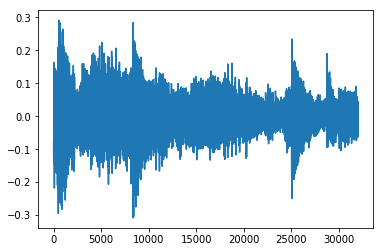

In [116]:
plot(Y_train[120][:].flatten())

In [41]:
def bidi_LSTM(X_t, num_notes, Y_t ):
    # define bidirectional LSTM configuration
    n_neurons_encoder = 128 # refers to size of Memory matrices (can be anything)
    # create LSTM
    model = Sequential()
    # encoder
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),input_shape=(X_t, num_notes)))
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),batch_input_shape = (n_neurons_encoder, n_neurons_encoder)))
    #model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),batch_input_shape = (nbatch,n_neurons_encoder,n_neurons_encoder)))
    model.add(TimeDistributed(Dense(400, activation=None)))

    return model

In [42]:
# compile model
model = bidi_LSTM(X_t,num_notes,Y_t)
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 80, 256)           312320    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80, 256)           394240    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 80, 400)           102800    
Total params: 809,360
Trainable params: 809,360
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
n_batch = 400#num_samples-10 # number of training examples 
n_epoch = 100
#print(model.summary())
# train LSTM
model.fit(X_train[:,0:100,:], Y_train[:,0:100,:], epochs=n_epoch, batch_size=n_batch)
# evaluate


Epoch 1/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0056
Epoch 2/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0056
Epoch 3/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0056
Epoch 4/100
2065/2065 [==============================] - 17s 8ms/step - loss: 0.0056
Epoch 5/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0055
Epoch 6/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0055
Epoch 7/100
2065/2065 [==============================] - 18s 8ms/step - loss: 0.0055
Epoch 8/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0055
Epoch 9/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0055
Epoch 10/100
2065/2065 [==============================] - 17s 8ms/step - loss: 0.0055
Epoch 11/100
2065/2065 [==============================] - 17s 8ms/step - loss: 0.0055
Epoch 12/100
2065/2065 [==============================] - 18s 9

2065/2065 [==============================] - 19s 9ms/step - loss: 0.0052
Epoch 97/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0052
Epoch 98/100
2065/2065 [==============================] - 19s 9ms/step - loss: 0.0052
Epoch 99/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0052
Epoch 100/100
2065/2065 [==============================] - 18s 9ms/step - loss: 0.0052


In [120]:
# evaluate model on training and test data
test_pred = model.predict(X_test, batch_size=n_batch)
train_pred = model.predict(X_train, batch_size=n_batch)

(2065, 80, 400)
(2065, 80, 400)


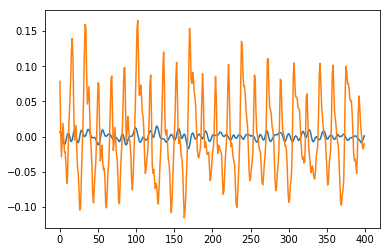

In [121]:
print(train_pred.shape)
print(Y_train.shape)

plot(train_pred[3,15,:].flatten())
plot(Y_train[3,15,:].flatten())


In [93]:
# save audio as mp3

y_train_flattened = Y_train.reshape(Y_train.size,1)
scaled = np.int16(y_train_flattened/np.max(np.abs(y_train_flattened))*32767)
write('y_train.mp3',8000,scaled)

y_test_flattened = Y_test.reshape(Y_test.size,1)
scaled = np.int16(y_test_flattened/np.max(np.abs(y_test_flattened))*32767)
write('y_test.mp3',8000,scaled)

# evaluate train
y_pred_train = model.predict(X_train, batch_size=n_batch)

y_pred_flattened = y_pred_train.reshape(y_pred_train.size,1)
scaled = np.int16(y_pred_flattened/np.max(np.abs(y_pred_flattened))*32767)
write('y_pred_train.mp3',8000,scaled)

# evaluate test
y_pred_test = model.predict(X_test, batch_size=n_batch)

y_pred_flattened = y_pred_test.reshape(y_pred_test.size,1)
scaled = np.int16(y_pred_flattened/np.max(np.abs(y_pred_flattened))*32767)
write('y_pred_test.mp3',8000,scaled)



In [104]:
mat_contents = io.loadmat('/Users/granty/Data/CS230_train/8kHz_dt05_keras_ex4.mat')
Xin = mat_contents['X']
Yout = mat_contents['Yout']
# evaluate train
y_pred_test_ex4 = model.predict(Xin, batch_size=n_batch)

y_pred_flattened = y_pred_test_ex4.reshape(y_pred_test_ex4.size,1)
scaled = np.int16(y_pred_flattened/np.max(np.abs(y_pred_flattened))*32767)
write('y_pred_test_ex4.mp3',8000,scaled)

y_out_flattened = Yout.reshape(Yout.size,1)
scaled = np.int16(y_out_flattened/np.max(np.abs(y_out_flattened))*32767)
write('y_test_ex4.mp3',8000,scaled)

In [122]:
# save model
nmodel = 100
filepath = 'run_full_epoch' + str(nmodel)
model.save(filepath)